# Lab 11: Grid Localization using Bayes Filter (Real Robot)

### <span style="color:rgb(0,150,0)">It is recommended that you close any heavy-duty applications running on your system while working on this lab.</span>

### <span style="color:rgb(0,150,0)">The notebook only provides skeleton code for you to integrate the Localization class with the Real Robot.</span>

<hr>

In [1]:
%load_ext autoreload
%autoreload 2

import traceback
from notebook_utils import *
from Traj import *
import asyncio
import pathlib
import os
from utils import load_config_params
from localization_extras import Localization

# The imports below will only work if you copied the required ble-related python files 
# into the notebooks directory
from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import numpy as np
import time

# Setup Logger
LOG = get_logger('demo_notebook.log')
LOG.propagate = False

# Init GUI and Commander
gui = GET_GUI()
cmdr = gui.launcher.commander

2023-05-11 16:26:00,334 | INFO     |: Logger demo_notebook.log initialized.


In [2]:
# Start the plotter
START_PLOTTER()

qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=850.746,394.531 gbl=850.746,394.531 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-850.746,-394.531 last=-850.746,-394.531 Δ 850.746,394.531) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=860.304,394.577 gbl=860.304,394.577 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-860.304,-394.577 last=-860.304,-394.577 Δ 860.304,394.577) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=880.441,398.207 gbl=880.441,398.207 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-880.441,-398.207 last=-880.441,-398.207 Δ 880.441,398.207) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=917.086,405.42 gbl=917.086,405.42 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-917.086,-405.42 last=-917.086,-405.42 Δ 917.086,405.42) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=975.183,418.573 gbl=975.183,418.573 Released ellipse=(1x1 ∡ 0

# The RealRobot class
Define the RealRobot class in the code cell below, based on the documentation and your real robot communication protocol. <br>
This class is used by the **Localization** class to communicate with the real robot. <br>
More specifically, the **Localization** class utilizes the **RealRobot's** member function **perform_observation_loop()** to get the 18 sensor readings and store them in its member variable **obs_range_data**, which is then utilized in the update step.

In [ ]:
# Disconnect
ble.disconnect()

In [3]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-05-11 16:27:44,675 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:24:6a:9a:3c
2023-05-11 16:27:47,578 | INFO     |: Connected to c0:83:24:6a:9a:3c


/Users/tiffanyguo/Desktop/ECE4160-code/ble_robot-1.1/FastRobots-sim-release-release-mirror/notebooks/base_ble.py:87: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [ ]:
[425, 534, 429, 384, 351, 368, 471, 817, 0, 296, 663, 583, 463, 161, 1073, 807, 609, 532]
[902, 635, 436, 386, 360, 389, 500, 695, 649, 694, 751, 250, 2008, 1762, 414, 970, 341, 902]
[469, 578, 897, 2286, 817, 908, 374, 451, 1179, 650, 404, 300, 277, 289, 346, 539, 595, 577]

In [4]:
ble.send_command(CMD.PID, "")

tof_times = []
tof_data = []
imu_data = []

def str_notify_handler(uuid, byte_array):
            global tof_times
            global tof_data
            global imu_data
            # print(byte_array)
            data = ble.bytearray_to_string(byte_array)
            print(data)

            tof_times.append(int(data[1 : data.index(',')]))
            data = data[data.index(',')+1:]
            tof_data.append(int(data[:data.index(',')]))
            data = data[data.index(',')+1:]
            imu_data.append(int(data[:-1]))
    
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
# ble.send_command(CMD.PID, "")

# begin_time = time.time()
# while(time.time() < begin_time + 55):
#     #give time for robot to rotate 360 degrees and collect data
#     pass

ble.send_command(CMD.SEND_DATA, "")

# print(tof_times)
# print(tof_data)
# print(imu_data)

0
20
41
60
80
101
120
140
160
181
200
220
241
260
280
301
320
340


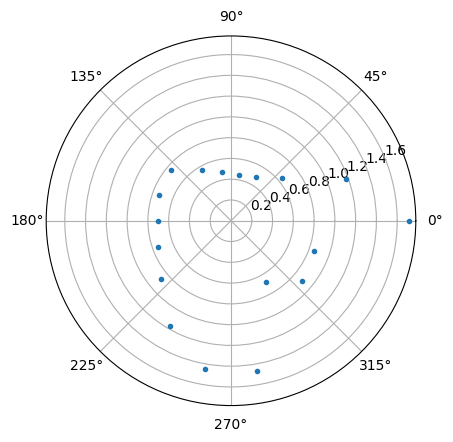

qt.pointer.dispatch: skipping QEventPoint(id=2 ts=0 pos=0,0 scn=490.188,425.101 gbl=490.188,425.101 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-490.188,-425.101 last=-490.188,-425.101 Δ 490.188,425.101) : no target window


In [17]:
from matplotlib import pyplot as plt
# print(tof_times)
# print(tof_data)
# print(imu_data)
# print(len(tof_times))
# print(len(tof_data))
# print(len(imu_data))
#save_data = tof_data
deg = [0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340]
deg_idx = 0;
map_data = []

for index in range(len(imu_data)):
    if((imu_data[index]-(imu_data[index]%10)) == deg[deg_idx]):
        print(imu_data[index])
        map_data.append(tof_data[index])
        deg_idx += 1
    if(deg_idx == 18):
        break
        
while(deg_idx < 18):
    map_data.append(tof_data[0])

rad = []
for i in deg:
    rad.append(i*math.pi/180)
# plt.polar(rad, map_data, '.')
# plt.title("Map (0, 0)")

return_data = [1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701, 0.751, 0.877, 1.166, 1.447, 1.465, 0.678, 0.898, 0.846]
plt.polar(rad, return_data, '.')

In [189]:
#tof_data = [1955, 752, 150, 435, 463, 580, 812, 700, 650, 706, 750, 1160, 2421, 1987, 2268, 1359, 949, 2029, 2000]
#[1955, 752, 150, 435, 463, 580, 812, 700, 650, 706, 750, 1160, 2421, 1987, 2268, 1359, 949, 2029, 2000]
#[1955, 752, 95, 435, 463, 580, 812, 725, 713, 706, 778, 1160, 2421, 1987, 2268, 1359, 949, 2029, 2000]

In [18]:
class RealRobot():
    """A class to interact with the real robot
    """
    def __init__(self, commander, ble):
        # Load world config
        self.world_config = os.path.join(str(pathlib.Path(os.getcwd()).parent), "config", "world.yaml")
        
        self.config_params = load_config_params(self.world_config)
        
        # Commander to commuincate with the Plotter process
        # Used by the Localization module to plot odom and belief
        self.cmdr = commander

        # ArtemisBLEController to communicate with the Robot
        self.ble = ble

    def get_pose(self):
        """Get robot pose based on odometry
        
        Returns:
            current_odom -- Odometry Pose (meters, meters, degrees)
        """
        raise NotImplementedError("get_pose is not implemented")

    def perform_observation_loop(self, rot_vel=120):
        """Perform the observation loop behavior on the real robot, where the robot does  
        a 360 degree turn in place while collecting equidistant (in the angular space) sensor
        readings, with the first sensor reading taken at the robot's current heading. 
        The number of sensor readings depends on "observations_count"(=18) defined in world.yaml.
        
        Keyword arguments:
            rot_vel -- (Optional) Angular Velocity for loop (degrees/second)
                        Do not remove this parameter from the function definition, even if you don't use it.
        Returns:
            sensor_ranges   -- A column numpy array of the range values (meters)
            sensor_bearings -- A column numpy array of the bearings at which the sensor readings were taken (degrees)
                               The bearing values are not used in the Localization module, so you may return a empty numpy array
        """
        
#         global tof_times
#         global tof_data
#         global imu_data
        
#         ble.send_command(CMD.PID, "")

#         begin_time = time.time()
#         while(time.time() < begin_time + 45):
#             #give time for robot to rotate 360 degrees and collect data
#             pass

#         ble.send_command(CMD.SEND_DATA, "")

        return_data = []
        zero_array = []
        for i in range(18):
            return_data.append(map_data[i]/1000)
            print(return_data)
            zero_array.append(0)
            
        return_data[-1] = return_data[0]
            
        sensor_ranges = np.array([return_data]).T
        sensor_bearings = np.array([zero_array]).T

        return sensor_ranges, sensor_bearings

In [37]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-05-11 15:59:15,812 | INFO     |: Already connected to a BLE device


In [19]:
# Initialize RealRobot with a Commander object to communicate with the plotter process
# and the ArtemisBLEController object to communicate with the real robot
robot = RealRobot(cmdr, ble)

# Initialize mapper
# Requires a VirtualRobot object as a parameter
mapper = Mapper(robot)

# Initialize your BaseLocalization object
# Requires a RealRobot object and a Mapper object as parameters
loc = Localization(robot, mapper)

## Plot Map
cmdr.plot_map()

2023-05-11 16:35:09,102 | INFO     |:  | Number of observations per grid cell: 18
2023-05-11 16:35:09,104 | INFO     |:  | Precaching Views...
2023-05-11 16:35:13,706 | INFO     |:  | Precaching Time: 4.600 secs
2023-05-11 16:35:13,707 | INFO     |: Initializing beliefs with a Uniform Distribution
2023-05-11 16:35:13,708 | INFO     |: Uniform Belief with each cell value: 0.00051440329218107


# Run an update step of the Bayes Filter

In [20]:
# Reset Plots
cmdr.reset_plotter()

# Init Uniform Belief
loc.init_grid_beliefs()

# Get Observation Data by executing a 360 degree rotation motion
loc.get_observation_data()

# Run Update Step
loc.update_step()
loc.plot_update_step_data(plot_data=True)

# Plot Odom and GT
# current_odom, current_gt = robot.get_pose()
cmdr.plot_gt(0*0.3048, 3*0.3048)
# cmdr.plot_gt(current_gt[0], current_gt[1])
# cmdr.plot_odom(current_odom[0], current_odom[1])

2023-05-11 16:35:14,720 | INFO     |: Initializing beliefs with a Uniform Distribution
2023-05-11 16:35:14,721 | INFO     |: Uniform Belief with each cell value: 0.00051440329218107
[1.716]
[1.716, 1.177]
[1.716, 1.177, 0.635]
[1.716, 1.177, 0.635, 0.485]
[1.716, 1.177, 0.635, 0.485, 0.451]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701, 0.751]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701, 0.751, 0.877]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701, 0.751, 0.877, 1.166]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701, 0.751, 0.877, 1.166, 1.447]
[1.716, 1.177, 0.635, 0.485, 0.451, 0.475, 0.56, 0.76, 0.733, 0.701, 0.751, 0.877, 1

In [194]:
# Start the simulator
STOP_SIM()

# Start the plotter
STOP_PLOTTER()

2023-05-09 09:19:01,032 | ERROR    |: Simulator is not running
2023-05-09 09:19:01,042 | INFO     |: Plotter is stopped
